In [26]:
import sys
# !{sys.executable} -m pip install idx2numpy

import requests
import numpy as np
np.random.seed(42)

import pandas as pd
import os
import idx2numpy
import gzip
import torch
torch.manual_seed(42)

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.autograd import Variable
import torch.nn as  nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

In [27]:
train_link = "/Users/alexevenson/Library/Mobile Documents/com~apple~CloudDocs/Kaggle/train.csv"
test_link = "/Users/alexevenson/Library/Mobile Documents/com~apple~CloudDocs/Kaggle/test.csv"

train_data = np.genfromtxt(train_link, delimiter=',')
test_data = np.genfromtxt(test_link, delimiter=',')



In [28]:
trainys = train_data[1:30001, 0].reshape(-1,1)
trainxs = refold_features(train_data[1:30001,1:])
validys = train_data[30001:, 0].reshape(-1,1)
validxs = refold_features(train_data[30001:,1:])
testxs = test_data[1:,:]
#Test y data does not exist, understandably


In [29]:
trainys

array([[1.],
       [0.],
       [1.],
       ...,
       [2.],
       [3.],
       [0.]])

In [30]:
def unfold_features(data):
    (Y, X, Z) = data.shape
    data = data.reshape(Y, X*Z)
    return data

def refold_features(data):
    (Y, X) = data.shape
    dim = int(np.sqrt(X))
    data = data.reshape(Y, dim, dim)
    return data

#Assert folding process is reversible
np.all(refold_features(unfold_features(trainxs)) == trainxs)


True

In [31]:
train_mean = np.mean(trainxs)

train_std = np.std(trainxs)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(train_mean,),
                         std=(train_std,))
])

class Dataset_loader(Dataset):
    def __init__(self, X, y, transform=None):
        self.data = X
        self.target = y
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]

        # Normalize your data here
        if self.transform:
            x = self.transform(x)

        return x, y
    
    def __len__(self):
        return len(self.data)

In [32]:
#Transform and batch all three datasets

train_set = Dataset_loader(trainxs, trainys, transform=transform)
train_set_loader = torch.utils.data.DataLoader(train_set, batch_size = 50, shuffle = True)

valid_set = Dataset_loader(validxs, validys, transform=transform)
valid_set_loader = torch.utils.data.DataLoader(valid_set, batch_size = 50, shuffle = True)

# test_set = Dataset_loader(testxs, testys, transform=transform)
# test_set_loader = torch.utils.data.DataLoader(test_set, batch_size = 50, shuffle = True)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


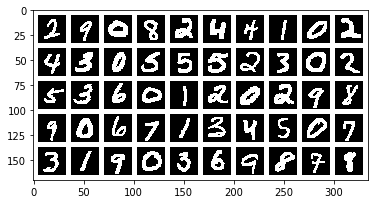

In [33]:
# Load a batch of training images for visualising
data_iterator = iter(train_set_loader)
images, labels = data_iterator.next()

# Create function for visualisation
def show_image(img):
    # revert the normalisation when displaying the images
    img = img * train_std + train_mean
    # Convert to numpy for visualisation
    npimg = img.numpy()
    # Plot each image
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# Plot images as a grid using the 'make_grid' function
show_image(torchvision.utils.make_grid(images,10,5))

plt.show();

In [34]:
class conv_net(nn.Module):
    
    #Define the layers in the init statement
    def __init__(self):
        
        super(conv_net, self).__init__()
        
        #Conv layers
        self.conv1 = nn.Conv2d(1, 10, kernel_size = 5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size = 5)
        
        #Dense layers
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50,10)
        
        self.losses = []
        self.accuracy = []
        
    def forward(self, x):
        # Apply a 2D max pooling over the output of the 1st convolutional layer
        x = F.max_pool2d(self.conv1(x), 2)
        # Add a ReLU activation function to the 1st convolutional layer
        x = F.relu(x)
        
        # Apply a 2D max pooling over the output of the 2nd convolutional layer
        x = F.max_pool2d(self.conv2(x), 2)
        # Add a ReLU activation function to the 2nd convolutional layer
        x = F.relu(x)
        
        # Flatten the output of the 2nd convolutional layer to feed into the next layer
        x = x.view(-1, 320)
        # Add a ReLU activation function to the 1st fully connected layer
        x = F.relu(self.fc1(x))
        # Add a log softmax activation function to the final layer
        ###############  TO DO Q3 ###############  
        
        x = F.log_softmax(self.fc2(x), dim=1)

        ###############  TO DO Q3 ###############  
        
        return x
    
    def train_net(self, train_set, no_epochs, lr):
        
        loss_func = nn.CrossEntropyLoss()
        optimiser = optim.Adam(net.parameters(), lr = lr)
        
        for epoch in range(no_epochs):
            
            current_loss = 0.0
            current_accuracy = 0.0
            
            #Loop over mini-batches
            for batch_index, training_batch in enumerate(train_set, 0):
                inputs, labels = training_batch
                
                
                inputs = inputs.float()
                labels = labels.long()
                inputs, labels = Variable(inputs), Variable(labels)
                
                print(inputs.shape)
                print(labels.shape)
                
                optimiser.zero_grad()
                outputs = self.forward(inputs)
                
                labels = labels.squeeze_(-1)

                loss = loss_func(outputs, labels)
                
                loss.backward()  #Propagate losses backwards
                optimiser.step() #Update weights
                
                current_loss += loss.item()  #Add batch loss to calculate epoch loss
                
                correct_pred = 0
                total_pred = 0
                
                for data in training_batch:
                    images, labels = training_batch
                    # Compute the predicted labels
                    images = images.float()
                    outputs = self.forward(Variable(images))
                    dummy, pred_labels = torch.max(outputs.data, 1)
                    pred_labels = pred_labels.view(-1,1)
                    
                    # Count the correct predictions
                    correct_pred += (pred_labels == labels).sum().item()
                    total_pred += pred_labels.size(0)
                
                current_accuracy += (100 * correct_pred) / total_pred
                
                #Compute average batch loss and accuracy every 300 batches
                if batch_index % 300 == 299:
                    print('[Epoch: %d Batch: %5d] loss: %.3f accuracy: %.3f' %
                         (epoch + 1, batch_index+1, current_loss / 300, current_accuracy / 300))
                    self.losses.append(current_loss/300)
                    self.accuracy.append(current_accuracy/300)

                    #reset the current loss and acc for the next batches

                    current_loss = 0.0
                    current_accuracy = 0.0

In [35]:
net = conv_net()
net = net.float()
net.train_net(train_set_loader, lr = 0.0005,  no_epochs = 15)



torch.Size([50, 1, 28, 28])
torch.Size([50, 1])
torch.Size([50, 1, 28, 28])
torch.Size([50, 1])
torch.Size([50, 1, 28, 28])
torch.Size([50, 1])
torch.Size([50, 1, 28, 28])
torch.Size([50, 1])
torch.Size([50, 1, 28, 28])
torch.Size([50, 1])
torch.Size([50, 1, 28, 28])
torch.Size([50, 1])
torch.Size([50, 1, 28, 28])
torch.Size([50, 1])
torch.Size([50, 1, 28, 28])
torch.Size([50, 1])
torch.Size([50, 1, 28, 28])
torch.Size([50, 1])
torch.Size([50, 1, 28, 28])
torch.Size([50, 1])
torch.Size([50, 1, 28, 28])
torch.Size([50, 1])
torch.Size([50, 1, 28, 28])
torch.Size([50, 1])
torch.Size([50, 1, 28, 28])
torch.Size([50, 1])
torch.Size([50, 1, 28, 28])
torch.Size([50, 1])
torch.Size([50, 1, 28, 28])
torch.Size([50, 1])
torch.Size([50, 1, 28, 28])
torch.Size([50, 1])
torch.Size([50, 1, 28, 28])
torch.Size([50, 1])
torch.Size([50, 1, 28, 28])
torch.Size([50, 1])
torch.Size([50, 1, 28, 28])
torch.Size([50, 1])
torch.Size([50, 1, 28, 28])
torch.Size([50, 1])
torch.Size([50, 1, 28, 28])
torch.Size([

torch.Size([50, 1, 28, 28])
torch.Size([50, 1])
torch.Size([50, 1, 28, 28])
torch.Size([50, 1])
torch.Size([50, 1, 28, 28])
torch.Size([50, 1])
torch.Size([50, 1, 28, 28])
torch.Size([50, 1])
torch.Size([50, 1, 28, 28])
torch.Size([50, 1])
torch.Size([50, 1, 28, 28])
torch.Size([50, 1])
torch.Size([50, 1, 28, 28])
torch.Size([50, 1])
torch.Size([50, 1, 28, 28])
torch.Size([50, 1])
torch.Size([50, 1, 28, 28])
torch.Size([50, 1])
torch.Size([50, 1, 28, 28])
torch.Size([50, 1])
torch.Size([50, 1, 28, 28])
torch.Size([50, 1])
torch.Size([50, 1, 28, 28])
torch.Size([50, 1])
torch.Size([50, 1, 28, 28])
torch.Size([50, 1])
torch.Size([50, 1, 28, 28])
torch.Size([50, 1])
torch.Size([50, 1, 28, 28])
torch.Size([50, 1])
torch.Size([50, 1, 28, 28])
torch.Size([50, 1])
torch.Size([50, 1, 28, 28])
torch.Size([50, 1])
torch.Size([50, 1, 28, 28])
torch.Size([50, 1])
torch.Size([50, 1, 28, 28])
torch.Size([50, 1])
torch.Size([50, 1, 28, 28])
torch.Size([50, 1])
torch.Size([50, 1, 28, 28])
torch.Size([

torch.Size([50, 1, 28, 28])
torch.Size([50, 1])
torch.Size([50, 1, 28, 28])
torch.Size([50, 1])
torch.Size([50, 1, 28, 28])
torch.Size([50, 1])
torch.Size([50, 1, 28, 28])
torch.Size([50, 1])
torch.Size([50, 1, 28, 28])
torch.Size([50, 1])
torch.Size([50, 1, 28, 28])
torch.Size([50, 1])
torch.Size([50, 1, 28, 28])
torch.Size([50, 1])
torch.Size([50, 1, 28, 28])
torch.Size([50, 1])
torch.Size([50, 1, 28, 28])
torch.Size([50, 1])
torch.Size([50, 1, 28, 28])
torch.Size([50, 1])
torch.Size([50, 1, 28, 28])
torch.Size([50, 1])
torch.Size([50, 1, 28, 28])
torch.Size([50, 1])
torch.Size([50, 1, 28, 28])
torch.Size([50, 1])
torch.Size([50, 1, 28, 28])
torch.Size([50, 1])
torch.Size([50, 1, 28, 28])
torch.Size([50, 1])
torch.Size([50, 1, 28, 28])
torch.Size([50, 1])
torch.Size([50, 1, 28, 28])
torch.Size([50, 1])
torch.Size([50, 1, 28, 28])
torch.Size([50, 1])
torch.Size([50, 1, 28, 28])
torch.Size([50, 1])
torch.Size([50, 1, 28, 28])
torch.Size([50, 1])
torch.Size([50, 1, 28, 28])
torch.Size([

KeyboardInterrupt: 

In [ ]:
#Check on the validation set

correct_pred = 0
total_pred = 0

for valid_data in valid_set_loader:
    valid_images, valid_labels = valid_data
    
    outputs = net.forward(Variable(valid_images).float())
    
    dummy, pred_labels = torch.max(outputs.data, 1)
    pred_labels = pred_labels.view(-1,1)
    
    correct_pred += (pred_labels == valid_labels).sum()
    total_pred += pred_labels.size(0)
    
print("Accuracy is %d %%" % (100 * correct_pred / total_pred))


In [ ]:
results = net.forward(torch.from_numpy(refold_features(testxs)[:, np.newaxis, :, :]).float())

finresults.argmax(dim=1)

In [ ]:
# results = results.argmax(dim=1)

results = results.numpy()

In [ ]:
results = pd.Series(results, index = range(1, len(results)+1))

In [ ]:
results = pd.DataFrame(results, columns = ['Label'])
results.index.name = "ImageId"
results.tail()

results.to_csv('./submission.csv')


